## Antarctic Intermediate Water (AAIW)

This notebook plots the buoyancy contribution to potential vorticity over the Pacific Sector of the Southern Ocean.

In [1]:
import os
import datetime

In [2]:
config = {
    "startyr": "1993",
    "endyr": "2017",
    "dora_id": "odiv-269",
    "pathPP": None,
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
)

### Import Python Modules

In [3]:
import glob
import subprocess

import doralite
import matplotlib.pyplot as plt
import momgrid as mg
import momlevel as ml
import numpy as np
import xarray as xr

In [4]:
# momgrid will use a directory of pre-computed weights
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Define Local Parameters

In [5]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Determine What Files to Load

In [6]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_annual_z"
static = f"{component}/{component}.static.nc"
varname = "ann"

chunk = "annual_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230720/om5_b00_cycle1/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1993-1997.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230720/om5_b00_cycle1/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1998-2002.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230720/om5_b00_cycle1/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2003-2007.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230720/om5_b00_cycle1/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2008-2012.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230720/om5_b00_cycle1/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2013-2017.ann.nc


### DMgetting Files

Dora cannot issue calls to dmget

In [7]:
if not "DORA_EXECUTE" in os.environ.keys():
    subprocess.run(["dmwho"])

MINUTES  USERNAME                  HOST    COMMAND FILES
    3.0  Ming.Zhao                 pp061   dmget      67
    2.2  Ming.Zhao                 pp030   dmput     120
    1.6  Ming.Zhao                 pp037   dmget      66
    0.8  Ming.Zhao                 pp331   dmget      64
    0.1  Ming.Zhao                 pp105   dmget       1
    0.1  Bosong.Zhang              pp336   dmget       1
    0.1  Bosong.Zhang              pp008   dmput       1


In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Establish a Dictionary to Store Scalar Metrics

In [9]:
stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
}
stats_dict["results"] = {}
stats_dict

{'metadata': {'expName': 'om5_b00_cycle1_c5',
  'created': '2024-02-12T11:16:23.884644'},
 'results': {}}

### Load model data and grid

In [10]:
ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
model_type = ds.model
ds = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

In [11]:
ds = ds.mean("time").sel(z_l=slice(0,2000))

In [12]:
zeta = 0.0
coriolis = ml.derived.calc_coriolis(ds.geolat)
n2 = ml.derived.calc_n2(ds.thetao, ds.so)
pv = ml.derived.calc_pv(zeta, coriolis, n2, interp_n2=False, units="cm")
pv = pv.transpose("z_l", "yh", "xh")
pv = pv.load()

In [13]:
levels, colors = ml.util.get_pv_colormap()

In [14]:
pv = mg.geoslice.geoslice(pv, x=(-180,-120),y=(-65,0))

In [15]:
yindex = pv.geolat.mean("xh")

### Calcualte the Volume

In [16]:
volcello = mg.geoslice.geoslice(ds.volcello, x=(-180,-120),y=(-65,0))

In [17]:
volume = xr.where(pv > 60.0, volcello, np.nan).sel(z_l=slice(700, None)).sum()
volume = volume.load()
print(f"Volume of water with PV > 60 cm-2 s-1: {float(volume)}")

Volume of water with PV > 60 cm-2 s-1: 4135276653838336.0


In [18]:
stats_dict["results"] = {"volume": float(volume)}

### Make zonal mean plot

In [19]:
# Take the zonal mean
pv = pv.weighted(ds.areacello).mean("xh")

In [20]:
pv = pv.transpose("z_l", "yh")

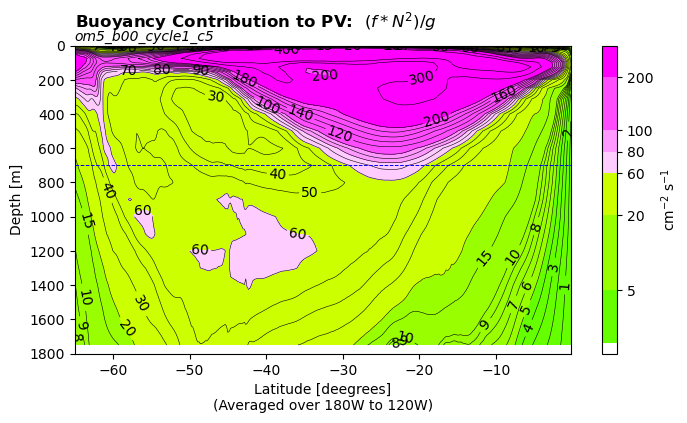

In [21]:
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = plt.subplot(1, 1, 1)
cb = ax.contourf(yindex, pv.z_l, pv, levels=levels, colors=colors)
cs = ax.contour(yindex, pv.z_l, pv, levels=levels, colors=["k"], linewidths=0.4)
ax.set_ylim(0, 1800.0)
ax.invert_yaxis()

_ = ax.set_xlabel("Latitude [deegrees]\n(Averaged over 180W to 120W)")
_ = ax.set_ylabel("Depth [m]")

ax.hlines(
    700, yindex.min(), yindex.max(), colors="blue", linestyles="dashed", linewidths=0.7
)

ax.clabel(cs)

_ = ax.text(
    0.0,
    1.06,
    r"Buoyancy Contribution to PV:  $(f * N^2)/g$",
    transform=ax.transAxes,
    fontsize=12,
    weight="bold",
)

_ = ax.text(
    0.0,
    1.015,
    expName,
    transform=ax.transAxes,
    fontsize=10,
    style="italic",
)

plt.colorbar(cb, ticks=[5, 20, 60, 80, 100, 200], label=r"cm$^{-2}$ s$^{-1}$")

### Plot Observations

In [22]:
dsobs = xr.open_dataset(
    "/archive/jpk/datasets/OM5/obs/RG_ArgoClim/RG_ArgoClim_TS.200401-201812.nc"
)
dsobs = dsobs.sel(xh=slice(180, 240)).sel(yh=slice(None, 0))

In [23]:
zeta = 0.0
coriolis = ml.derived.calc_coriolis(dsobs.geolat)
n2 = ml.derived.calc_n2(dsobs.thetao, dsobs.so)
pv = ml.derived.calc_pv(zeta, coriolis, n2, interp_n2=False, units="cm")
pv = pv.transpose("z_l", "yh", "xh")

In [24]:
# Infer cell bounds
lat = pv.geolat[:, 0].values
lon = pv.geolon[0, :].values
lat_b = mg.util.infer_bounds(lat)
lon_b = mg.util.infer_bounds(lon)

# Calculate cell area
area = mg.util.standard_grid_area(lat_b, lon_b)
area = xr.DataArray(area, dims=("yh", "xh"), coords={"yh": pv.yh, "xh": pv.xh})

# Calculate cell volume
depth = (area * 0.0) + dsobs.z_i[-1]
dz = ml.derived.calc_dz(dsobs.z_l, dsobs.z_i, depth)
volcello = dz * area

# Volume of high-PV water
volume = xr.where(pv > 60.0, volcello, np.nan).sel(z_l=slice(700, None)).sum()

print(f"Volume of water with PV > 60 cm-2 s-1: {float(volume)}")

Volume of water with PV > 60 cm-2 s-1: 9084359415955456.0


In [25]:
# Take the zonal mean
pv = pv.weighted(area).mean("xh")

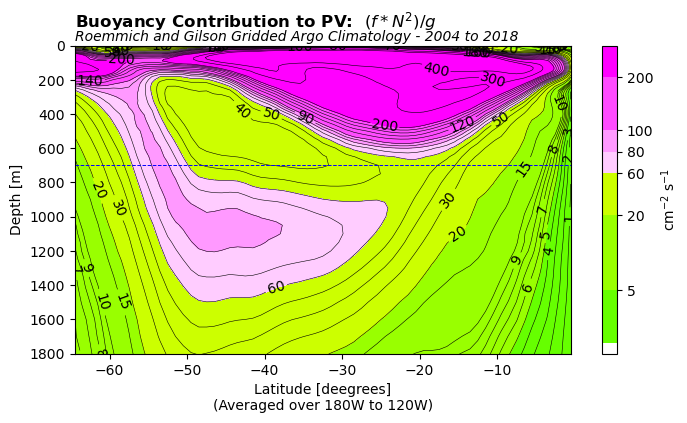

In [26]:
fig = plt.figure(figsize=(8, 4), dpi=100)
ax = plt.subplot(1, 1, 1)
cb = ax.contourf(dsobs.yh, dsobs.z_l, pv, levels=levels, colors=colors)
cs = ax.contour(dsobs.yh, dsobs.z_l, pv, levels=levels, colors=["k"], linewidths=0.4)
ax.set_ylim(0, 1800.0)
# ax.set_xlim(None,0)
ax.invert_yaxis()

_ = ax.set_xlabel("Latitude [deegrees]\n(Averaged over 180W to 120W)")
_ = ax.set_ylabel("Depth [m]")

ax.hlines(
    700, pv.yh.min(), pv.yh.max(), colors="blue", linestyles="dashed", linewidths=0.7
)

ax.clabel(cs)

_ = ax.text(
    0.0,
    1.06,
    r"Buoyancy Contribution to PV:  $(f * N^2)/g$",
    transform=ax.transAxes,
    fontsize=12,
    weight="bold",
)

_ = ax.text(
    0.0,
    1.015,
    r"Roemmich and Gilson Gridded Argo Climatology - 2004 to 2018",
    transform=ax.transAxes,
    fontsize=10,
    style="italic",
)

plt.colorbar(cb, ticks=[5, 20, 60, 80, 100, 200], label=r"cm$^{-2}$ s$^{-1}$")

### Write Stats to a File

In [27]:
if not "DORA_EXECUTE" in os.environ.keys():
    import yaml
    yml = yaml.dump(stats_dict)
    with open('aaiw_pv.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)

metadata:
  created: '2024-02-12T11:16:23.884644'
  expName: om5_b00_cycle1_c5
results:
  volume: 4135276653838336.0

